# Evaluation

In [1]:
import editdistance
from tqdm import trange
from tqdm import tqdm
import numpy as np
from utils import dna
import random
import torch
import math
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
max_k = 6
# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)

In [2]:
batch_num = 2 # how many batch used for computing distance
batch_size = 64

## Load training set and validation set

In [3]:
#data_loc = "../data/prom400"
data_loc = "../data/human"
seq_len = 300

train_set_loc = data_loc + '/train.txt'
val_set_loc = data_loc + '/val.txt'

markov_loc = data_loc + '/markovBaseline'

# sample from val set
#random.seed(42)
with open(val_set_loc) as f:
    lines = f.read().split('\n')
#samplesVal = random.sample(lines, k=batch_size*batch_num)
samplesVal = lines[:batch_size*batch_num]
# random.seed(123)
#samplesVal1 = random.sample(lines, k=batch_size*batch_num)
samplesVal1 = lines[batch_size*batch_num:2*batch_size*batch_num]
# random.seed(42)
# with open(train_set_loc) as f:
#     lines = f.read().split('\n')
# samplesTrain = random.sample(lines, k=batch_size*batch_num)

In [24]:
path = {
    'wgp5r': '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgangp2007',
    'snwgp5r': '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/snwgp5res2203',
    'wgp': '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgp2201',
    'snwgp': '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/snwgp2201',
}

In [4]:
path = {
    'wgp5r': '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgp5res3001',
    'snwgp5r': '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/snwgp5res0401',
    'wgp5r32': '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgp5res32_0401',
    'wgp': '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgp3001',
    'wgpm': '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgpm0401',
    'wgps': '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgps0401',
    #'wgp1': '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgp3002',
}

## Baselines

In [5]:
randomBase = [''.join(random.choice("ATGC") for _ in range(seq_len)) for _ in range(batch_num * batch_size)]

In [6]:
markovBase = {}
for k in range(1, 7):
    with open(os.path.join(markov_loc, f"{k}.txt")) as f:
        lines = f.read().split('\n')
    markovBase[k] = lines

## Generated Data Loader function

In [7]:
charmap = dna.get_vocab('ATGC')

charlist = [0,0,0,0]
for char in charmap:
    charlist[charmap[char]] = char

def sampleAndConvertGeneratedOneHot2Seqs(sampleFileName, batch_num=2):
    # convert one-hot form into sequence form, return list of sequences
    samples = np.load(sampleFileName)
    samples = samples.transpose((0, 1, 3, 2))
    max_indice = []
    for batch in samples[0:batch_num]:
        for sample in batch:
            max_indice.append(np.argmax(sample, axis=1))
    max_indice = np.array(max_indice)
    #print(max_indice)

    seqs = np.take(charlist, max_indice)
    samples = []
    for seq in seqs:
        samples.append(seq.tobytes().decode().replace('\x00', ''))
    return samples

## Edit distance

In [16]:
def editDistanceBetweenTwoSeqs(seq1, seq2):
    return editdistance.eval(seq1, seq2)
    
def averageEditDistanceBetweenTwoSets(seqs1, seqs2):
    distances = []
    for i in range(len(seqs1)):
        for j in range(len(seqs2)):
            distances.append(editDistanceBetweenTwoSeqs(seqs1[i], seqs2[j]))
    return np.array(distances).mean()
def computeAllEditDistances(experimentPath):
    #experimentPath = '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgangp2007'
    samplesPath = experimentPath + '/samples'
    sample_names = [f for f in os.listdir(samplesPath) if os.path.isfile(os.path.join(samplesPath, f))]
    iterations = []
    d_gs_rs = []
    d_gs_gs = []
    for sample_name in tqdm(sample_names):
        iterations.append(int(sample_name.split('_')[1].split('.')[0]))
        samplesGen = sampleAndConvertGeneratedOneHot2Seqs(os.path.join(samplesPath, sample_name))
        d_gs_rs.append(averageEditDistanceBetweenTwoSets(samplesGen, samplesVal))
        d_gs_gs.append(averageEditDistanceBetweenTwoSets(samplesGen, samplesGen))
    #sort by iterations
    all_edit_distance = np.stack((iterations, d_gs_rs, d_gs_gs))
    all_edit_distance = all_edit_distance[:,all_edit_distance[0].argsort()]
    np.save(os.path.join(experimentPath, 'editDistance.npy'), all_edit_distance)

In [107]:
def editDistanceMatrixBetweenTwoSets(seqs1, seqs2):
    distances = np.zeros((len(seqs1), len(seqs2)))
    for i in range(len(seqs1)):
        for j in range(len(seqs2)):
            distances[i, j] = editDistanceBetweenTwoSeqs(seqs1[i], seqs2[j])
    return np.array(distances)
def computeEditDistancesMatrices(experimentPath):
    #experimentPath = '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgangp2007'
    samplesPath = experimentPath + '/samples'
    sample_names = [f for f in os.listdir(samplesPath) if os.path.isfile(os.path.join(samplesPath, f))]
    last_iter = max([int(sample_name.split('_')[1].split('.')[0]) for sample_name in sample_names])

    samplesGen = sampleAndConvertGeneratedOneHot2Seqs(os.path.join(samplesPath, 'iter_'+str(last_iter)+'.npy'))
    inter = editDistanceMatrixBetweenTwoSets(samplesGen, samplesVal)
    within = editDistanceMatrixBetweenTwoSets(samplesGen, samplesGen)
    return inter, within

In [108]:
inter, within = computeEditDistancesMatrices(path['wgp5r'])

In [117]:
bench = editDistanceMatrixBetweenTwoSets(samplesVal1, samplesVal)
rand = editDistanceMatrixBetweenTwoSets(randomBase, samplesVal)

In [109]:
inter.shape

(128, 128)

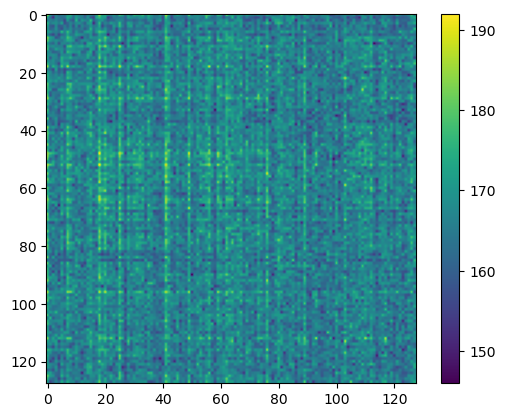

In [118]:
plt.imshow(rand)
plt.colorbar()

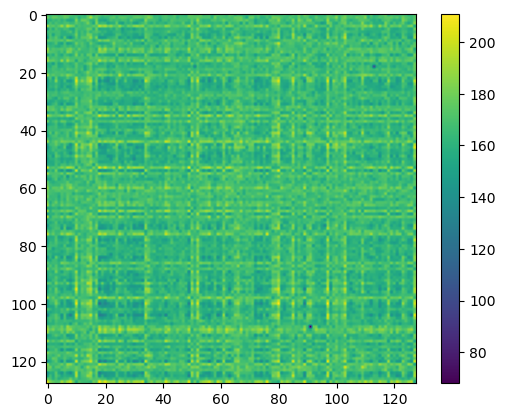

In [116]:
plt.imshow(bench)
plt.colorbar()

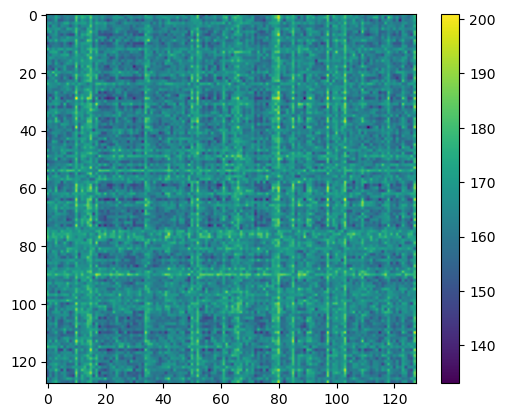

In [114]:
plt.imshow(inter)
plt.colorbar()

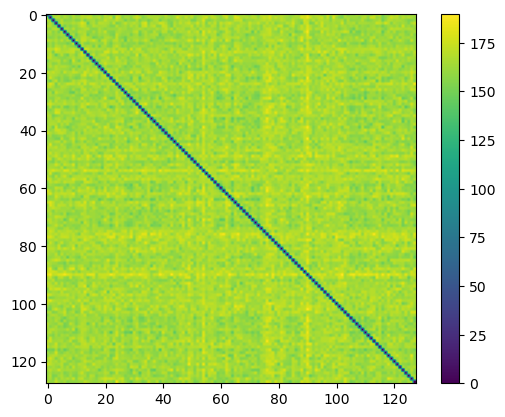

In [113]:
plt.imshow(within)
plt.colorbar()

In [71]:
pathToComputeDistance = ['snwgp5r']

In [74]:
for experiment in pathToComputeDistance:
    computeAllEditDistances(path[experiment])

100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


In [21]:
d_rs1_rs = averageEditDistanceBetweenTwoSets(samplesVal1, samplesVal)
d_rs_rs = averageEditDistanceBetweenTwoSets(samplesVal, samplesVal)
d_rd_rs = averageEditDistanceBetweenTwoSets(randomBase, samplesVal)
d_rd_rd = averageEditDistanceBetweenTwoSets(randomBase, randomBase)

In [17]:
d_ts_rs = averageEditDistanceBetweenTwoSets(samplesTrain, samplesVal)

In [22]:
d_mk_rs = []
d_mk_mk = []
for k in range(1, 7):
    d_mk_rs.append(averageEditDistanceBetweenTwoSets(markovBase[k], samplesVal))
    d_mk_mk.append(averageEditDistanceBetweenTwoSets(markovBase[k], markovBase[k]))

In [28]:
d_wgp5r = np.load('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgangp2007/editDistance.npy')
d_snwgp5r = np.load('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/snwgp5res2203/editDistance.npy')
d_wgp = np.load('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgp2201/editDistance.npy')
d_snwgp = np.load('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/snwgp2201/editDistance.npy')

In [75]:
d_wgp5r = np.load('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgp5res3001/editDistance.npy')
d_snwgp5r = np.load('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/snwgp5res0401/editDistance.npy')
d_wgp5r32 = np.load('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgp5res32_0401/editDistance.npy')
d_wgp = np.load('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgp3001/editDistance.npy')
d_wgps = np.load('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgps0401/editDistance.npy')
d_wgpm = np.load('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgpm0401/editDistance.npy')

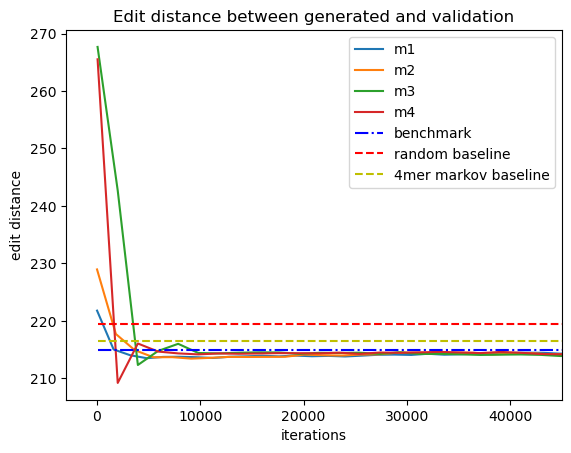

In [36]:
plt.plot(d_wgp5r[0], d_wgp5r[1], label="m1") 
plt.plot(d_snwgp5r[0], d_snwgp5r[1], label="m2") 
plt.plot(d_wgp[0], d_wgp[1], label="m3") 
plt.plot(d_snwgp[0], d_snwgp[1], label="m4") 
plt.hlines(d_rs1_rs, xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='-.', label='benchmark', color='b')
plt.hlines(d_rd_rs, xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='random baseline', color='r')
plt.hlines(d_mk_rs[5], xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='4mer markov baseline', color='y')
#plt.hlines(d_ts_rs, xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='train set sample', color='y')
#plt.xticks(all_edit_distance[0], rotation=75)
plt.xlim([-3000, 45000])
plt.xlabel('iterations')
plt.ylabel('edit distance')
plt.title('Edit distance between generated and validation')
plt.legend()
plt.show()

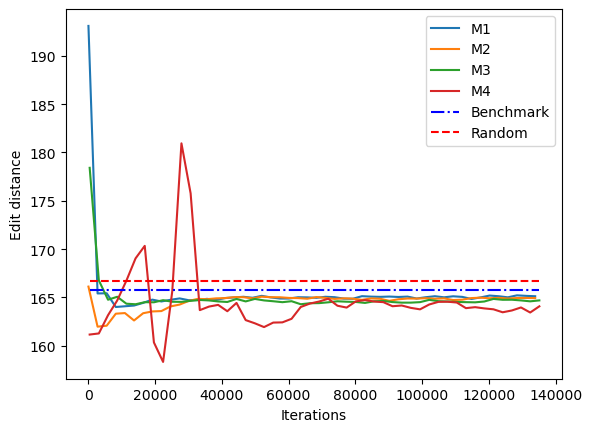

In [90]:
plt.plot(d_wgp5r[0], d_wgp5r[1], label="M1") 
plt.plot(d_wgp5r32[0], d_wgp5r32[1], label="M2") 
#plt.plot(d_wgp[0], d_wgp[1], label="m3") 
plt.plot(d_wgpm[0], d_wgpm[1], label="M3") 
plt.plot(d_wgps[0], d_wgps[1], label="M4") 
#plt.plot(d_snwgp5r[0], d_snwgp5r[1], label="m5") 
#plt.plot(d_wgp1[0], d_wgp1[1], label="m4") 
# plt.hlines(d_mk_rs[0], xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='1mer markov')
# plt.hlines(d_mk_rs[1], xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='2mer markov')#, color='y')
# plt.hlines(d_mk_rs[2], xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='3mer markov')
# plt.hlines(d_mk_rs[3], xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='4mer markov')
# plt.hlines(d_mk_rs[4], xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='5mer markov')
# plt.hlines(d_mk_rs[5], xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='6mer markov')

#plt.hlines(d_mk_rs[3], xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='4mer markov baseline', color='y')
plt.hlines(d_rs1_rs, xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='-.', label='Benchmark', color='b')
plt.hlines(d_rd_rs, xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='Random', color='r')

#plt.hlines(d_ts_rs, xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='train set sample', color='y')
#plt.xticks(all_edit_distance[0], rotation=75)
#plt.xlim([-3000, 45000])
plt.xlabel('Iterations')
plt.ylabel('Edit distance')
#plt.title('Edit distance ')
plt.legend()
plt.show()

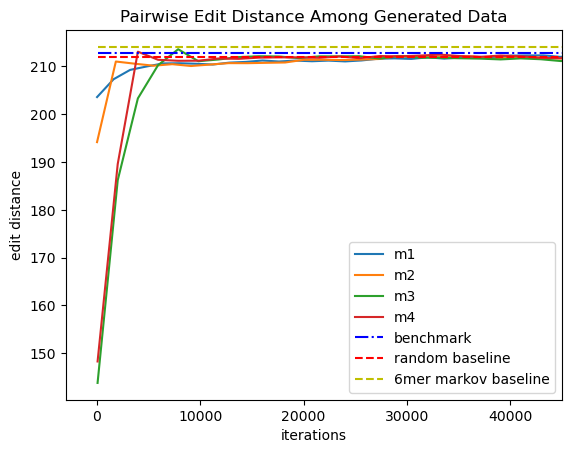

In [38]:
plt.plot(d_wgp5r[0], d_wgp5r[2], label="m1") 
plt.plot(d_snwgp5r[0], d_snwgp5r[2], label="m2") 
plt.plot(d_wgp[0], d_wgp[2], label="m3")  
plt.plot(d_snwgp[0], d_snwgp[2], label="m4") 
plt.hlines(d_rs_rs, xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='-.', label='benchmark', color='b')
plt.hlines(d_rd_rd, xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='random baseline', color='r')
plt.hlines(d_mk_mk[1], xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='6mer markov baseline', color='y')
#plt.xticks(all_edit_distance[0], rotation=75)
plt.xlim([-3000, 45000])
plt.xlabel('iterations')
plt.ylabel('edit distance')
plt.title('Pairwise Edit Distance Among Generated Data')
plt.legend()
plt.show()

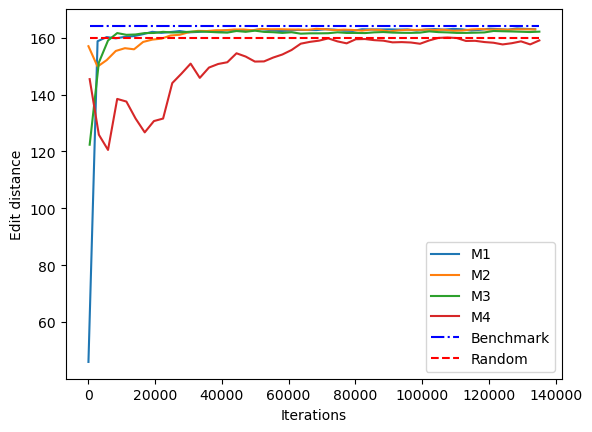

In [92]:
plt.plot(d_wgp5r[0], d_wgp5r[2], label="M1") 
plt.plot(d_wgp5r32[0], d_wgp5r32[2], label="M2") 
# plt.plot(d_snwgp5r[0], d_snwgp5r[2], label="m2") 
#plt.plot(d_wgp[0], d_wgp[2], label="m3")  
plt.plot(d_wgpm[0], d_wgpm[2], label="M3")  
plt.plot(d_wgps[0], d_wgps[2], label="M4") 
#plt.plot(d_snwgp5r[0], d_snwgp5r[2], label="m5")  
# plt.plot(d_snwgp[0], d_snwgp[2], label="m4") 
plt.hlines(d_rs_rs, xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='-.', label='Benchmark', color='b')
plt.hlines(d_rd_rd, xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='Random', color='r')
# plt.hlines(d_mk_mk[5], xmin=d_wgp[0][0], xmax=d_wgp[0][-1], linestyle='--', label='6mer markov baseline', color='y')
#plt.xticks(all_edit_distance[0], rotation=75)
# plt.xlim([-3000, 45000])
plt.xlabel('Iterations')
plt.ylabel('Edit distance')
#plt.title('Pairwise Edit Distance Among Generated Data')
plt.legend()
plt.show()

### Old code

In [ ]:
indices = []
d_inters = []
d_reals = []
for i in trange(1, 31):
    sampleFileName = train_sample_loc + f'iter_{i*100}.npy'
    samples = train_sample(sampleFileName, batch_num)
    indices.append(i)
    d_inters.append(distance(samples, samples))
    d_reals.append(distance(samples, samplesReal))
d_inter_real = distance(samplesReal, samplesReal)
d_real1_real = distance(samplesReal1, samplesReal)

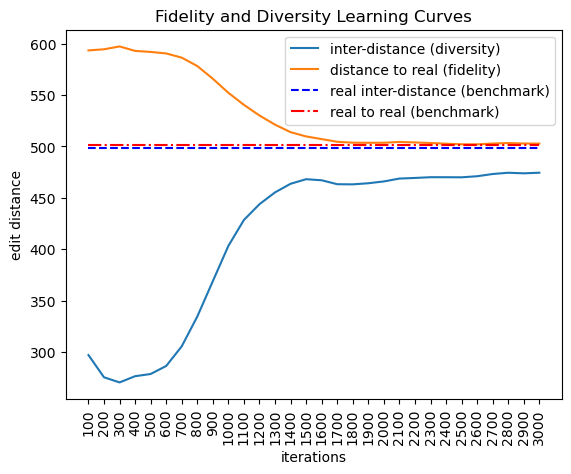

In [49]:
plt.plot(indices, d_inters, label='inter-distance (diversity)')
plt.plot(indices, d_reals, label='distance to real (fidelity)')
plt.hlines(d_inter_real, xmin=indices[0], xmax=indices[-1], linestyle='--', label='real inter-distance (benchmark)', color='b')
plt.hlines(d_real1_real, xmin=indices[0], xmax=indices[-1], linestyle='-.', label='real to real (benchmark)', color='r')
plt.title('Fidelity and Diversity Learning Curves')
plt.xticks(indices, np.array(indices)*100, rotation=90)
plt.xlabel('iterations')
plt.ylabel('edit distance')
plt.legend()
plt.show()

## K-mer frequency

In [36]:
def generate_kmers(k):
    return [''.join(x) for x in itertools.product('ATGC', repeat=k)]

def kmer_frequencies(dataset, k):
    kmers = generate_kmers(k)
    frequencies = {kmer: 0 for kmer in kmers}
    for sequence in dataset:
        for i in range(len(sequence) - k + 1):
            kmer = sequence[i:i + k]
            frequencies[kmer] += 1
    total_kmers = sum(frequencies.values())
    for kmer in frequencies:
        frequencies[kmer] /= total_kmers
    frequencies = [frequencies[kmer] for kmer in kmers]
    return frequencies

In [37]:
def computeAllKmerCorelation(experimentPath, max_k=6):
    #experimentPath = '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgangp2007'
    samplesPath = experimentPath + '/samples'
    sample_names = [f for f in os.listdir(samplesPath) if os.path.isfile(os.path.join(samplesPath, f))]
    #max_k = 6
    pcc_r2 = {}
    for k in trange(1, max_k + 1):
        freqs_val = kmer_frequencies(samplesVal, k)
        iterations = []
        pcc_gs_rs = []
        r2_gs_rs = []
        for sample_name in sample_names:
            iterations.append(int(sample_name.split('_')[1].split('.')[0]))
            samplesGen = sampleAndConvertGeneratedOneHot2Seqs(os.path.join(samplesPath, sample_name))
            freqs_sample = kmer_frequencies(samplesGen, k)
            pcc, _ = pearsonr(freqs_sample, freqs_val)
            r2 = r2_score(freqs_sample, freqs_val)
            pcc_gs_rs.append(pcc)
            r2_gs_rs.append(r2)
        pcc_r2_kmer = np.stack((iterations, pcc_gs_rs, r2_gs_rs))
        pcc_r2_kmer = pcc_r2_kmer[:,pcc_r2_kmer[0].argsort()]
        pcc_r2[k] = pcc_r2_kmer

    # np.save(os.path.join(experimentPath, 'editDistance.npy'), all_edit_distance)
    return pcc_r2

In [ ]:
kmer_wgp5r = computeAllKmerCorelation('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgangp2007')
kmer_snwgp5r = computeAllKmerCorelation('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/snwgp5res2203')
kmer_wgp = computeAllKmerCorelation('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgp2201')
kmer_snwgp = computeAllKmerCorelation('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/snwgp2201')

In [81]:
kmer_wgp5r = computeAllKmerCorelation('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgp5res3001')
# kmer_wgp5r32 = computeAllKmerCorelation('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgp5res32_0401')
# #kmer_wgp = computeAllKmerCorelation('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgp3001')
# kmer_wgpm = computeAllKmerCorelation('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgpm0401')
# kmer_wgps = computeAllKmerCorelation('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgps0401')
kmer_snwgp5r = computeAllKmerCorelation('/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/snwgp5res0401')

100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


In [39]:
pcc_r2_bench = {}
for k in trange(1, max_k + 1):
    freqs_val = kmer_frequencies(samplesVal, k)
    freqs_val1 = kmer_frequencies(samplesVal1, k)
    # print(freqs_val.shape)
    # print(freqs_val1.shape)

    pcc, _ = pearsonr(freqs_val1, freqs_val)
    r2 = r2_score(freqs_val1, freqs_val)
    pcc_r2_bench[k] = (pcc, r2)

100%|██████████| 6/6 [00:00<00:00, 71.27it/s]


In [40]:
pcc_r2_random = {}
for k in trange(1, max_k + 1):
    freqs_val = kmer_frequencies(samplesVal, k)
    freqs_base = kmer_frequencies(randomBase, k)

    pcc, _ = pearsonr(freqs_base, freqs_val)
    r2 = r2_score(freqs_base, freqs_val)
    pcc_r2_random[k] = (pcc, r2)

100%|██████████| 6/6 [00:00<00:00, 61.80it/s]


In [41]:
pcc_r2_markov = {}
for i in trange(1, 7):
    samplesMarkov = markovBase[i]
    pcc_r2 = {}
    for k in range(1, max_k + 1):
        freqs_val = kmer_frequencies(samplesVal, k)
        freqs_base = kmer_frequencies(samplesMarkov, k)

        pcc, _ = pearsonr(freqs_base, freqs_val)
        r2 = r2_score(freqs_base, freqs_val)
        pcc_r2[k] = (pcc, r2)
    pcc_r2_markov[i] = pcc_r2

100%|██████████| 6/6 [00:00<00:00, 12.01it/s]


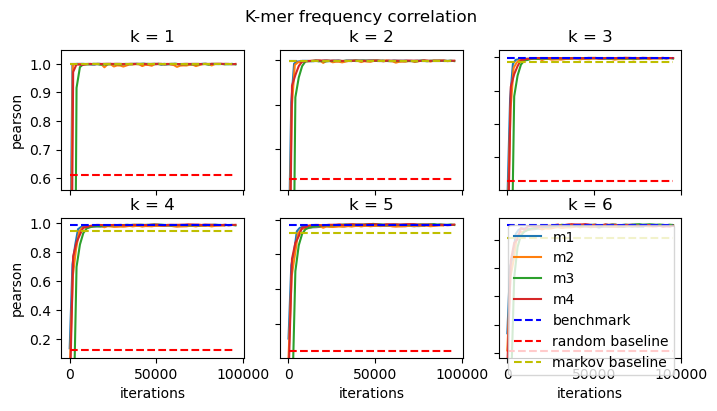

In [45]:
fig, axs = plt.subplots(2, 3, figsize=(8, 4))
for i, ax in enumerate(axs.flat):
    ax.plot(kmer_wgp5r[i+1][0], kmer_wgp5r[i+1][1], label='m1')
    ax.plot(kmer_snwgp5r[i+1][0], kmer_snwgp5r[i+1][1], label='m2')
    ax.plot(kmer_wgp[i+1][0], kmer_wgp[i+1][1], label='m3')
    ax.plot(kmer_snwgp[i+1][0], kmer_snwgp[i+1][1], label='m4')
    ax.hlines(pcc_r2_bench[i+1][0], xmin=kmer_wgp[i+1][0][0], xmax=kmer_wgp[i+1][0][-1], linestyle='--', label='benchmark', color='b')
    ax.hlines(pcc_r2_random[i+1][0], xmin=kmer_wgp[i+1][0][0], xmax=kmer_wgp[i+1][0][-1], linestyle='--', label='random baseline', color='r')
    ax.hlines(pcc_r2_markov[1][i+1][0], xmin=kmer_wgp[i+1][0][0], xmax=kmer_wgp[i+1][0][-1], linestyle='--', label='markov baseline', color='y')
    ax.set_ylim([pcc_r2_random[i+1][0]-0.05, pcc_r2_bench[i+1][0]+0.05])
    ax.set_title(f'k = {i+1}')
    ax.set(xlabel='iterations', ylabel='pearson')
    ax.label_outer()
    if i == 5:
        ax.legend()
#plt.tight_layout()

fig.suptitle("K-mer frequency correlation")
plt.show()

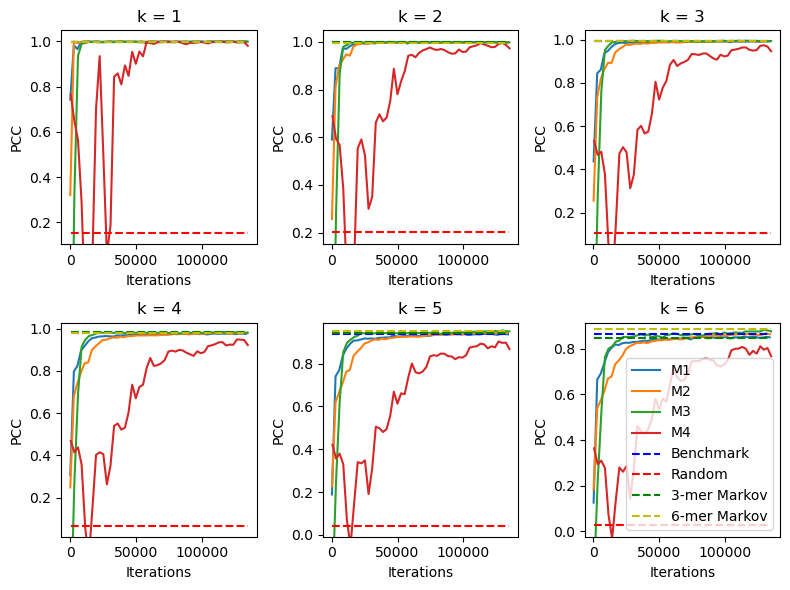

In [136]:
fig, axs = plt.subplots(2, 3, figsize=(8, 6))
for i, ax in enumerate(axs.flat):
    ax.plot(kmer_wgp5r[i+1][0], kmer_wgp5r[i+1][1], label='M1')
    ax.plot(kmer_wgp5r32[i+1][0], kmer_wgp5r32[i+1][1], label='M2')
    #ax.plot(kmer_snwgp5r[i+1][0], kmer_snwgp5r[i+1][1], label='m2')
    #ax.plot(kmer_wgp[i+1][0], kmer_wgp[i+1][1], label='m3')
    ax.plot(kmer_wgpm[i+1][0], kmer_wgpm[i+1][1], label='M3')
    ax.plot(kmer_wgps[i+1][0], kmer_wgps[i+1][1], label='M4')
    #ax.plot(kmer_snwgp5r[i+1][0], kmer_snwgp5r[i+1][1], label='m5')
    #ax.plot(kmer_snwgp[i+1][0], kmer_snwgp[i+1][1], label='m4')
    ax.hlines(pcc_r2_bench[i+1][0], xmin=kmer_wgp[i+1][0][0], xmax=kmer_wgp[i+1][0][-1], linestyle='--', label='Benchmark', color='b')
    ax.hlines(pcc_r2_random[i+1][0], xmin=kmer_wgp[i+1][0][0], xmax=kmer_wgp[i+1][0][-1], linestyle='--', label='Random', color='r')
    ax.hlines(pcc_r2_markov[3][i+1][0], xmin=kmer_wgp[i+1][0][0], xmax=kmer_wgp[i+1][0][-1], linestyle='--', label='3-mer Markov', color='g')
    ax.hlines(pcc_r2_markov[6][i+1][0], xmin=kmer_wgp[i+1][0][0], xmax=kmer_wgp[i+1][0][-1], linestyle='--', label='6-mer Markov', color='y')
    ax.set_ylim([pcc_r2_random[i+1][0]-0.05, pcc_r2_bench[i+1][0]+0.05])
    ax.set_title(f'k = {i+1}')
    ax.set(xlabel='Iterations', ylabel='PCC')
    #ax.label_outer()
    if i == 5:
        ax.legend()
plt.tight_layout()

#fig.suptitle("K-mer frequency correlation")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for i, ax in enumerate(axs.flat):
    ax.plot(kmer_wgp5r[i+5][0], kmer_wgp5r[i+5][1], label='m1')
    ax.plot(kmer_snwgp5r[i+5][0], kmer_snwgp5r[i+5][1], label='m2')
    ax.plot(kmer_wgp[i+5][0], kmer_wgp[i+5][1], label='m3')
    ax.plot(kmer_snwgp[i+5][0], kmer_snwgp[i+5][1], label='m4')
    ax.hlines(pcc_r2_bench[i+5][0], xmin=kmer_wgp[i+5][0][0], xmax=kmer_wgp[i+5][0][-1], linestyle='--', label='benchmark', color='b')
    ax.hlines(pcc_r2_random[i+5][0], xmin=kmer_wgp[i+5][0][0], xmax=kmer_wgp[i+5][0][-1], linestyle='--', label='random baseline', color='r')
    ax.hlines(pcc_r2_markov[3][i+5][0], xmin=kmer_wgp[i+5][0][0], xmax=kmer_wgp[i+5][0][-1], linestyle='--', label='markov baseline', color='y')
    ax.set_ylim([-0.05, 1+0.05])
    ax.set_title(f'k = {i+5}')
    ax.set(xlabel='iterations', ylabel='pearson')
    if i == 1:
        ax.legend()
    #ax.label_outer()
plt.tight_layout()
fig.suptitle("K-mer frequency correlation")
plt.show()

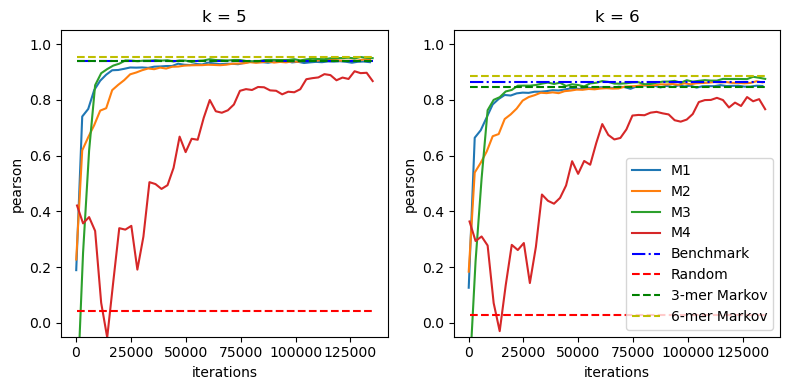

In [137]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for i, ax in enumerate(axs.flat):
    ax.plot(kmer_wgp5r[i+5][0], kmer_wgp5r[i+5][1], label='M1')
    ax.plot(kmer_wgp5r32[i+5][0], kmer_wgp5r32[i+5][1], label='M2')
    #ax.plot(kmer_snwgp5r[i+5][0], kmer_snwgp5r[i+5][1], label='m2')
    #ax.plot(kmer_wgp[i+5][0], kmer_wgp[i+5][1], label='m3')
    ax.plot(kmer_wgpm[i+5][0], kmer_wgpm[i+5][1], label='M3')
    ax.plot(kmer_wgps[i+5][0], kmer_wgps[i+5][1], label='M4')
    #ax.plot(kmer_snwgp5r[i+5][0], kmer_snwgp5r[i+5][1], label='m5')
    #ax.plot(kmer_snwgp[i+5][0], kmer_snwgp[i+5][1], label='m4')
    ax.hlines(pcc_r2_bench[i+5][0], xmin=kmer_wgp[i+5][0][0], xmax=kmer_wgp[i+5][0][-1], linestyle='-.', label='Benchmark', color='b')
    ax.hlines(pcc_r2_random[i+5][0], xmin=kmer_wgp[i+5][0][0], xmax=kmer_wgp[i+5][0][-1], linestyle='--', label='Random', color='r')
    ax.hlines(pcc_r2_markov[3][i+5][0], xmin=kmer_wgp[i+5][0][0], xmax=kmer_wgp[i+5][0][-1], linestyle='--', label='3-mer Markov', color='g')
    ax.hlines(pcc_r2_markov[6][i+5][0], xmin=kmer_wgp[i+5][0][0], xmax=kmer_wgp[i+5][0][-1], linestyle='--', label='6-mer Markov', color='y')
    ax.set_ylim([-0.05, 1+0.05])
    ax.set_title(f'k = {i+5}')
    ax.set(xlabel='iterations', ylabel='pearson')
    if i == 1:
        ax.legend()
    #ax.label_outer()
plt.tight_layout()
#fig.suptitle("K-mer frequency correlation")
plt.show()

### Old code

In [20]:
max_k = 6
indices = range(1, 31)
pccss = []
r2ss = []
for k in trange(1, max_k+1):
    freqs_real = kmer_frequencies(samplesReal, k)
    pccs = []
    r2s = []
    for i in range(1, 31):
        sampleFileName = train_sample_loc + f'iter_{i*100}.npy'
        samples = train_sample(sampleFileName, batch_num)
        freqs_sample = kmer_frequencies(samples, k)
        pcc, _ = pearsonr(freqs_sample, freqs_real)
        r2 = r2_score(freqs_sample, freqs_real)
        pccs.append(pcc)
        r2s.append(r2)
    pccss.append(pccs)
    r2ss.append(r2s)

100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


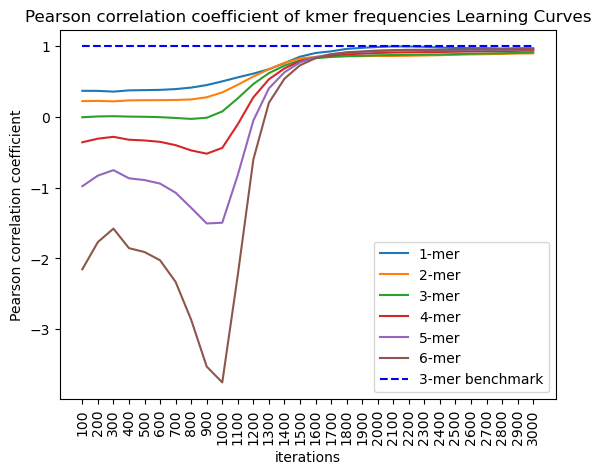

In [21]:
for k in range(1, max_k+1):
    plt.plot(indices, r2ss[k-1], label=f'{k}-mer')
plt.hlines(pcc_real1, xmin=indices[0], xmax=indices[-1], linestyle='--', label='3-mer benchmark', color='b')
plt.title('Pearson correlation coefficient of kmer frequencies Learning Curves')
plt.xticks(indices, np.array(indices)*100, rotation=90)
plt.xlabel('iterations')
plt.ylabel('Pearson correlation coefficient')
plt.legend()
plt.show()

## 3. DNABERT Features

### 3.1 Coefficient

In [39]:
def calculatePccR2(features1, features2):
    avg1 = features1.mean(axis=1)
    avg2 = features2.mean(axis=1)
    pcc, _ = pearsonr(avg1, avg2)
    r2 = r2_score(avg1, avg2)
    return pcc, r2
    

In [54]:
def computeBertCorelation(experimentPath, fea_val):
    #experimentPath = '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgangp2007'
    featuresPath = experimentPath + '/features'
    file_names = [f for f in os.listdir(featuresPath) if os.path.isfile(os.path.join(featuresPath, f))]
    iterations = []
    pcc_gs_rs = []
    r2_gs_rs = []
    for file_name in file_names:
        iterations.append(int(file_name.split('.')[0]))
        features = np.load(os.path.join(featuresPath, file_name))
        pcc, r2 = calculatePccR2(features, fea_val)
        pcc_gs_rs.append(pcc)
        r2_gs_rs.append(r2)
    pcc_r2 = np.stack((iterations, pcc_gs_rs, r2_gs_rs))
    pcc_r2 = pcc_r2[:,pcc_r2[0].argsort()]

    # np.save(os.path.join(experimentPath, 'editDistance.npy'), all_edit_distance)
    return pcc_r2

In [45]:
fea_val = np.load(data_loc + '/feature_val.npy')
fea_val1 = np.load(data_loc + '/feature_val1.npy')
fea_random = np.load(data_loc + '/feature_base.npy')
pcc_bench, r2_bench =  calculatePccR2(fea_val1, fea_val)
pcc_random, r2_random = calculatePccR2(fea_random, fea_val)
pcc_markov = {}
r2_markov = {}
for k in range(1, 7):
    fea_markov = np.load(f'../data/markovBaseline/{k}.npy')
    pcc_markov[k], r2_markov[k] = calculatePccR2(fea_markov[:-1], fea_val)

In [55]:
pcc_r2_wgp5r = computeBertCorelation(path['wgp5r'], fea_val)
pcc_r2_snwgp5r = computeBertCorelation(path['snwgp5r'], fea_val)
pcc_r2_wgp = computeBertCorelation(path['wgp'], fea_val)
pcc_r2_snwgp = computeBertCorelation(path['snwgp'], fea_val)

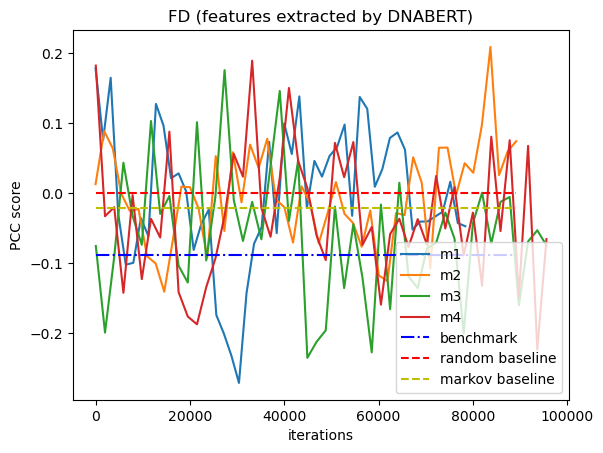

In [57]:
plt.plot(pcc_r2_wgp5r[0], pcc_r2_wgp5r[1], label='m1')
plt.plot(pcc_r2_snwgp5r[0], pcc_r2_snwgp5r[1], label='m2')
plt.plot(pcc_r2_wgp[0], pcc_r2_wgp[1], label='m3')
plt.plot(pcc_r2_snwgp[0], pcc_r2_snwgp[1], label='m4')
plt.hlines(pcc_bench, xmin=pcc_r2_snwgp5r[0][0], xmax=pcc_r2_snwgp5r[0][-1], linestyle='-.', label='benchmark', color='b')
plt.hlines(pcc_random, xmin=pcc_r2_snwgp5r[0][0], xmax=pcc_r2_snwgp5r[0][-1], linestyle='--', label='random baseline', color='r')
plt.hlines(pcc_markov[6], xmin=pcc_r2_snwgp5r[0][0], xmax=pcc_r2_snwgp5r[0][-1], linestyle='--', label='markov baseline', color='y')
plt.title('FD (features extracted by DNABERT)')
#plt.xticks(indices, np.array(indices)*100, rotation=90)
plt.xlabel('iterations')
plt.ylabel('PCC score')
plt.legend()
plt.show()

### 3.1 FD

In [11]:
from scipy.linalg import sqrtm

### Code for FID calculate

In [12]:
def calculate_fid(features_real, features_generated):
    mu_real = np.mean(features_real, axis=0)
    sigma_real = np.cov(features_real, rowvar=False)

    mu_generated = np.mean(features_generated, axis=0)
    sigma_generated = np.cov(features_generated, rowvar=False)

    mean_diff_squared = np.sum((mu_real - mu_generated) ** 2)

    # Calculate the trace of the sum of the covariances
    sigma_sum = sigma_real + sigma_generated
    sigma_sqrt = sqrtm(sigma_real.dot(sigma_generated))

    # Check for complex numbers due to numerical inaccuracies
    if np.iscomplexobj(sigma_sqrt):
        sigma_sqrt = sigma_sqrt.real

    # Calculate the trace of the difference between the square root of product of covariances
    trace_diff = np.trace(sigma_sum - 2 * sigma_sqrt)

    # Calculate the FID score
    fid_score = mean_diff_squared + trace_diff
    return fid_score

In [ ]:
# fea_val = np.load(data_loc + '/feature_val.npy')
# fea_val1 = np.load(data_loc + '/feature_val1.npy')
# fea_random = np.load(data_loc + '/feature_random.npy')
# fd_bench = calculate_fid(fea_val, fea_val1)
# fd_random = calculate_fid(fea_val, fea_random)
# fd_markov = {}
# for k in range(1, 7):
#     fea_markov = np.load(f'../data/markovBaseline/{k}.npy')
#     fd_markov[k] = calculate_fid(fea_val, fea_markov)

In [13]:
fea_val = np.load(data_loc + '/miniFeature_val.npy')
fea_val1 = np.load(data_loc + '/miniFeature_val1.npy')
fea_random = np.load(data_loc + '/miniFeature_random.npy')
fd_bench = calculate_fid(fea_val, fea_val1)
fd_random = calculate_fid(fea_val, fea_random)
fd_markov = {}
for k in range(1, 7):
    fea_markov = np.load(data_loc + f'/markovBaseline/{k}.npy')
    fd_markov[k] = calculate_fid(fea_val, fea_markov)

In [8]:
def loadAndComputeFID(experimentPath, features_val, featureFolder="/feature"):
    #experimentPath = '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgangp2007'
    featuresPath = experimentPath + featureFolder
    file_names = [f for f in os.listdir(featuresPath) if os.path.isfile(os.path.join(featuresPath, f))]
    iterations = []
    fids = []
    for file_name in tqdm(file_names):
        iterations.append(int(file_name.split('.')[0]))
        features = np.load(os.path.join(featuresPath, file_name))
        fids.append(calculate_fid(fea_val, features))
    #sort by iterations
    all_fids = np.stack((iterations, fids))
    all_fids = all_fids[:,all_fids[0].argsort()]
    return all_fids

In [ ]:
featureFolder = "/miniFeatures"
fd_wgp5r = loadAndComputeFID(path['wgp5r'], fea_val, featureFolder)
fd_snwgp5r = loadAndComputeFID(path['snwgp5r'], fea_val, featureFolder)
fd_wgp = loadAndComputeFID(path['wgp'], fea_val, featureFolder)
fd_snwgp = loadAndComputeFID(path['snwgp'], fea_val, featureFolder)

In [9]:
featureFolder = "/miniFeatures"
fd_wgp5r = loadAndComputeFID(path['wgp5r'], fea_val, featureFolder)
fd_wgp5r32 = loadAndComputeFID(path['wgp5r32'], fea_val, featureFolder)
# fd_snwgp5r = loadAndComputeFID(path['snwgp5r'], fea_val)
#fd_wgp = loadAndComputeFID(path['wgp'], fea_val, featureFolder)
fd_wgpm = loadAndComputeFID(path['wgpm'], fea_val, featureFolder)
fd_wgps = loadAndComputeFID(path['wgps'], fea_val, featureFolder)
fd_snwgp5r = loadAndComputeFID(path['snwgp5r'], fea_val, featureFolder)
# fd_snwgp = loadAndComputeFID(path['snwgp'], fea_val)

100%|██████████| 50/50 [00:04<00:00, 10.76it/s]


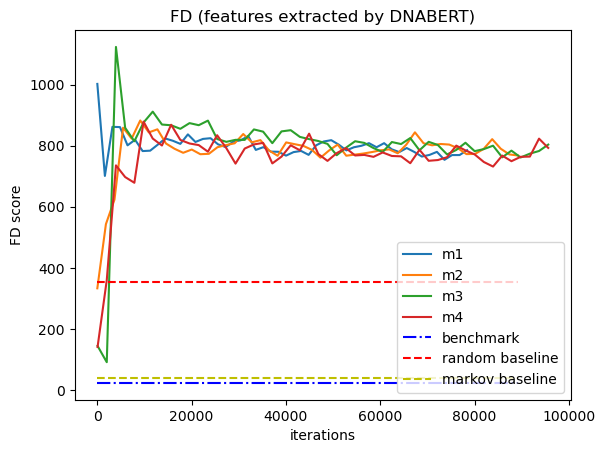

In [54]:
plt.plot(fd_wgp5r[0], fd_wgp5r[1], label='m1')
plt.plot(fd_snwgp5r[0], fd_snwgp5r[1], label='m2')
plt.plot(fd_wgp[0], fd_wgp[1], label='m3')
plt.plot(fd_snwgp[0], fd_snwgp[1], label='m4')
plt.hlines(fd_bench, xmin=fd_snwgp5r[0][0], xmax=fd_snwgp5r[0][-1], linestyle='-.', label='benchmark', color='b')
plt.hlines(fd_random, xmin=fd_snwgp5r[0][0], xmax=fd_snwgp5r[0][-1], linestyle='--', label='random baseline', color='r')
plt.hlines(fd_markov[6], xmin=fd_snwgp5r[0][0], xmax=fd_snwgp5r[0][-1], linestyle='--', label='markov baseline', color='y')
plt.title('FD (features extracted by DNABERT)')
#plt.xticks(indices, np.array(indices)*100, rotation=90)
plt.xlabel('iterations')
plt.ylabel('FD score')
plt.legend()
plt.show()

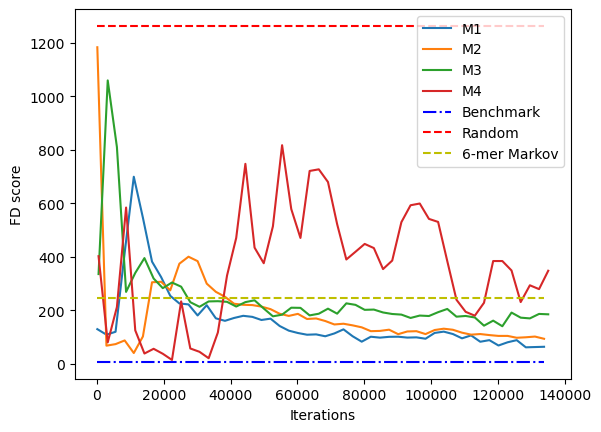

In [19]:
plt.plot(fd_wgp5r[0], fd_wgp5r[1], label='M1')
plt.plot(fd_wgp5r32[0], fd_wgp5r32[1], label='M2')
# plt.plot(fd_snwgp5r[0], fd_snwgp5r[1], label='m2')
#plt.plot(fd_wgp[0], fd_wgp[1], label='m3')
plt.plot(fd_wgpm[0], fd_wgpm[1], label='M3')
plt.plot(fd_wgps[0], fd_wgps[1], label='M4')
#plt.plot(fd_snwgp5r[0], fd_snwgp5r[1], label='m5')
# plt.plot(fd_snwgp[0], fd_snwgp[1], label='m4')
plt.hlines(fd_bench, xmin=fd_wgp5r[0][0], xmax=fd_wgp5r[0][-1], linestyle='-.', label='Benchmark', color='b')
plt.hlines(fd_random, xmin=fd_wgp5r[0][0], xmax=fd_wgp5r[0][-1], linestyle='--', label='Random', color='r')
plt.hlines(fd_markov[6], xmin=fd_wgp5r[0][0], xmax=fd_wgp5r[0][-1], linestyle='--', label='6-mer Markov', color='y')
#plt.title('FD (features extracted by miniDNABERT)')
#plt.xticks(indices, np.array(indices)*100, rotation=90)
plt.xlabel('Iterations')
plt.ylabel('FD score')
plt.legend()
plt.show()

## PCA

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [14]:
pca = PCA(n_components=2)
scaler = StandardScaler()

scaled_val = scaler.fit_transform(fea_val)
scaled_val1 = scaler.transform(fea_val1)

pca_val = pca.fit_transform(scaled_val)
pca_val1 = pca.transform(scaled_val1) 

In [16]:
scaled_random = scaler.transform(fea_random)
pca_random = pca.transform(scaled_random) 

In [22]:
scaled_markov = scaler.transform(np.load(data_loc + f'/markovBaseline/{6}.npy'))
pca_markov = pca.transform(scaled_markov) 

In [25]:
experimentPath = path['wgp5r']
featuresPath = experimentPath + "/miniFeatures"
file_names = [f for f in os.listdir(featuresPath) if os.path.isfile(os.path.join(featuresPath, f))]
last_iter = max([int(file_name.split('.')[0]) for file_name in file_names])
features = np.load(os.path.join(featuresPath, str(last_iter)+'.npy'))
scaled_wgp5r = scaler.transform(features)
pca_wgp5r = pca.transform(scaled_wgp5r) 

In [30]:
def jitter(arr):
    stdev = .05*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

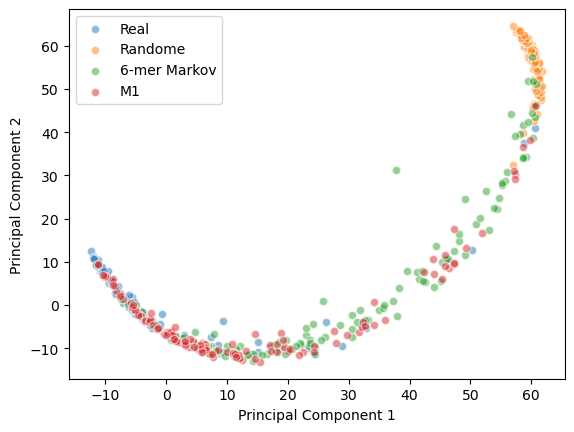

In [27]:
import matplotlib.pyplot as plt

plt.scatter(pca_val[:, 0], pca_val[:, 1], alpha=0.5, edgecolor='white', label='Real')
#plt.scatter(pca_val1[:, 0], pca_val1[:, 1], alpha=0.5, edgecolor='white',label='Real sample1')
plt.scatter(pca_random[:, 0], pca_random[:, 1], alpha=0.5, edgecolor='white',label='Randome')
plt.scatter(pca_markov[:, 0], pca_markov[:, 1], alpha=0.5, edgecolor='white',label='6-mer Markov')
plt.scatter(pca_wgp5r[:, 0], pca_wgp5r[:, 1], alpha=0.5, edgecolor='white',label='M1')

plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

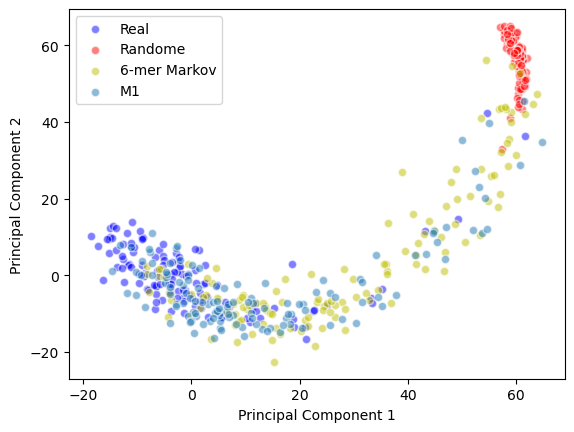

In [32]:
import matplotlib.pyplot as plt

plt.scatter(jitter(pca_val[:, 0]), jitter(pca_val[:, 1]), alpha=0.5, edgecolor='white', color='b',label='Real')
#plt.scatter(pca_val1[:, 0], pca_val1[:, 1], alpha=0.5, edgecolor='white',label='Real sample1')
plt.scatter(jitter(pca_random[:, 0]), jitter(pca_random[:, 1]), alpha=0.5, edgecolor='white', color='r', label='Randome')
plt.scatter(jitter(pca_markov[:, 0]), jitter(pca_markov[:, 1]), alpha=0.5, edgecolor='white',color='y', label='6-mer Markov')
plt.scatter(jitter(pca_wgp5r[:, 0]), jitter(pca_wgp5r[:, 1]), alpha=0.5, edgecolor='white',label='M1')

plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## MMD

In [5]:
import torch
import numpy as np
from torch_two_sample.statistics_diff import MMDStatistic

In [34]:
from sklearn.metrics.pairwise import rbf_kernel

def compute_mmd(X, Y, gamma=0.01):
    # Compute the pairwise kernel values
    X_kernel = rbf_kernel(X, X, gamma=gamma)
    Y_kernel = rbf_kernel(Y, Y, gamma=gamma)
    XY_kernel = rbf_kernel(X, Y, gamma=gamma)

    # Compute the mean values
    m = X.shape[0]
    n = Y.shape[0]

    term1 = np.sum(X_kernel) / (m * m)
    term2 = np.sum(Y_kernel) / (n * n)
    term3 = 2 * np.sum(XY_kernel) / (m * n)

    # Compute MMD
    mmd = term1 - term3 + term2
    return mmd
def computeMMD(features1, features2):
    return compute_mmd(features1, features2)

In [20]:
fea_val = np.load(data_loc + '/miniFeature_val.npy')
fea_val1 = np.load(data_loc + '/miniFeature_val1.npy')
fea_random = np.load(data_loc + '/miniFeature_random.npy')

In [35]:
mmd_bench = computeMMD(fea_val, fea_val1)
mmd_random = computeMMD(fea_val, fea_random)
mmd_markov = {}
for k in range(1, 7):
    fea_markov = np.load(data_loc + f'/markovBaseline/{k}.npy')
    mmd_markov[k] = computeMMD(fea_val, fea_markov)

In [36]:
def loadAndComputeMMD(experimentPath, features_val, featureFolder="/miniFeatures"):
    #experimentPath = '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgangp2007'
    featuresPath = experimentPath + featureFolder
    file_names = [f for f in os.listdir(featuresPath) if os.path.isfile(os.path.join(featuresPath, f))]
    iterations = []
    mmds = []
    # ps = []
    # for file_name in tqdm(file_names):
    #     iterations.append(int(file_name.split('.')[0]))
    #     features = np.load(os.path.join(featuresPath, file_name))
    #     mmd, p = computeMMD(fea_val, features)
    #     mmds.append(mmd)
    #     ps.append(p)
    # #sort by iterations
    # all_mmds = np.stack((iterations, mmds, ps))

    for file_name in tqdm(file_names):
        iterations.append(int(file_name.split('.')[0]))
        features = np.load(os.path.join(featuresPath, file_name))
        mmd= computeMMD(fea_val, features)
        mmds.append(mmd)
    #sort by iterations
    all_mmds = np.stack((iterations, mmds))
    all_mmds = all_mmds[:,all_mmds[0].argsort()]
    return all_mmds

In [37]:
mmd_wgp5r = loadAndComputeMMD(path['wgp5r'], fea_val)
mmd_wgp5r32 = loadAndComputeMMD(path['wgp5r32'], fea_val)
mmd_wgpm = loadAndComputeMMD(path['wgpm'], fea_val)
mmd_wgps = loadAndComputeMMD(path['wgps'], fea_val)

100%|██████████| 50/50 [00:00<00:00, 412.42it/s]


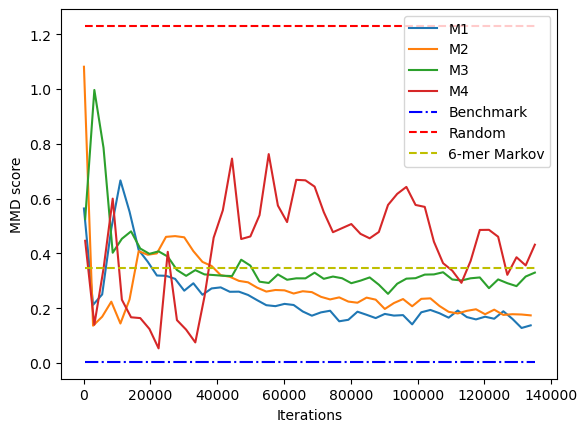

In [39]:
plt.plot(mmd_wgp5r[0], mmd_wgp5r[1], label='M1')
plt.plot(mmd_wgp5r32[0], mmd_wgp5r32[1], label='M2')
plt.plot(mmd_wgpm[0], mmd_wgpm[1], label='M3')
plt.plot(mmd_wgps[0], mmd_wgps[1], label='M4')
plt.hlines(mmd_bench, xmin=mmd_wgps[0][0], xmax=mmd_wgps[0][-1], linestyle='-.', label='Benchmark', color='b')
plt.hlines(mmd_random, xmin=mmd_wgps[0][0], xmax=mmd_wgps[0][-1], linestyle='--', label='Random', color='r')
plt.hlines(mmd_markov[6], xmin=mmd_wgps[0][0], xmax=mmd_wgps[0][-1], linestyle='--', label='6-mer Markov', color='y')
#plt.title('FD (features extracted by DNABERT)')
#plt.xticks(indices, np.array(indices)*100, rotation=90)
plt.xlabel('Iterations')
plt.ylabel('MMD score')
plt.legend()
plt.show()

In [ ]:
plt.plot(mmd_wgp5r[0], mmd_wgp5r[2], label='m1')
plt.plot(mmd_snwgp5r[0], mmd_snwgp5r[2], label='m2')
plt.plot(mmd_wgp[0], mmd_wgp[2], label='m3')
plt.plot(mmd_snwgp[0], mmd_snwgp[2], label='m4')
plt.hlines(p_bench, xmin=mmd_snwgp5r[0][0], xmax=mmd_snwgp5r[0][-1], linestyle='-.', label='benchmark', color='b')
# plt.hlines(mmd_random, xmin=mmd_snwgp5r[0][0], xmax=mmd_snwgp5r[0][-1], linestyle='--', label='random baseline', color='r')
# plt.hlines(mmd_markov[6], xmin=mmd_snwgp5r[0][0], xmax=mmd_snwgp5r[0][-1], linestyle='--', label='markov baseline', color='y')
plt.title('FD (features extracted by DNABERT)')
#plt.xticks(indices, np.array(indices)*100, rotation=90)
plt.xlabel('iterations')
plt.ylabel('FD score')
plt.legend()
plt.show()

In [ ]:
# old code
n=128
mmd_test = MMDStatistic(n,n)
def computeMMD(features1, features2, kernel_alphas=[0.1]):
    features1 = torch.from_numpy(features1.astype(np.float32))
    features2 = torch.from_numpy(features2.astype(np.float32))
    mmd, matrix = mmd_test(
        features1, 
        features2,
        alphas=kernel_alphas,
        ret_matrix=True
    )
    return mmd, mmd_test.pval(matrix)

mmd_bench, p_bench = computeMMD(fea_val, fea_val1)
mmd_random, p_random = computeMMD(fea_val, fea_random)
mmd_markov = {}
p_markov = {}
for k in range(1, 7):
    fea_markov = np.load(data_loc + f'/markovBaseline/{k}.npy')
    mmd_markov[k], p_markov[k] = computeMMD(fea_val, fea_markov)

def loadAndComputeTorchMMD(experimentPath, features_val, featureFolder="/miniFeatures"):
    #experimentPath = '/data/gpfs/projects/punim1021/yixiangw3/expressionGAN/runs/wgangp2007'
    featuresPath = experimentPath + featureFolder
    file_names = [f for f in os.listdir(featuresPath) if os.path.isfile(os.path.join(featuresPath, f))]
    iterations = []
    mmds = []
    ps = []
    for file_name in tqdm(file_names):
        iterations.append(int(file_name.split('.')[0]))
        features = np.load(os.path.join(featuresPath, file_name))
        mmd, p = computeMMD(fea_val, features)
        mmds.append(mmd)
        ps.append(p)
    #sort by iterations
    all_mmds = np.stack((iterations, mmds, ps))
    all_mmds = all_mmds[:,all_mmds[0].argsort()]
    return all_mmds

In [5]:
fea_val = np.load(data_loc + '/feature_val.npy')
fea_val1 = np.load(data_loc + '/feature_val1.npy')
fea_random = np.load(data_loc + '/feature_base.npy')

In [6]:
fea_val.shape

(128, 768)

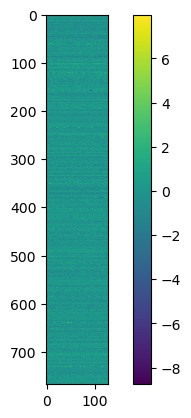

In [11]:
plt.imshow(fea_val.T)
plt.colorbar()

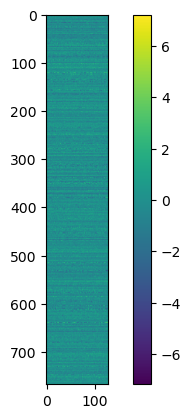

In [12]:
plt.imshow(fea_random.T)
plt.colorbar()

In [15]:
featuresPath = path['wgp5r'] + '/features'
file_names = [f for f in os.listdir(featuresPath) if os.path.isfile(os.path.join(featuresPath, f))]

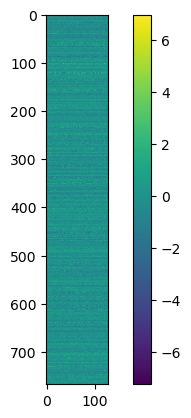

In [16]:
plt.imshow(np.load(os.path.join(featuresPath, file_names[-1])).T)
plt.colorbar()